![title](images/header.png)

# Ve - Supervised Classification of eSBAE with CAFI data - multiple models
-------
This notebook performs a supervised classification of eSBAE points based on the validated data from systematic points (2015-2022) for training
This script estimates several models of forest change (deforestation, degradation, stable, NF) based on the visually interpreted data and eSBAE variables. 
The models are then combined to assign categories of change to all systematic points
This script requires an m16 or r16 instance to run
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [ ]:
#pip install --user git+https://github.com/BuddyVolly/sampling-handler
#!pip install xgboost

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import uuid
from matplotlib import pyplot as plt
import seaborn as sns

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling

from imblearn import FunctionSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

import folium
import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.10/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


In [2]:
# country area (ha)
#GAB
#study_area = 26287600
#DRC
#study_area = 232798200
#COG
study_area = 34402400
#CMR
#study_area = 46497000
#EQG
#study_area = 2685800
#CAR
#study_area = 62009300

# 1 - data preparation

## 1.1 - Import merged esbae and CEO interpreted data
Import the merged dataset from script 5e - with all the eSBAE columns

In [3]:
#ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/EQG/EQG_esbae_ceo_1522_merge.csv', delimiter=',')
#ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_esbae_ceo_1522_merge.csv', delimiter=',')
#ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_esbae_ceo_1522_merge.csv', delimiter=',')
ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/COG/COG_esbae_ceo_1522_merge.csv', delimiter=',')
ceo_esbae_1522.head()

,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,red_min,red_max,nir_mean,nir_sd,nir_min,nir_max,swir1_mean,swir1_sd,swir1_min,swir1_max,swir2_mean,swir2_sd,swir2_min,swir2_max,ndfi_mean,ndfi_sd,ndfi_min,ndfi_max,brightness_mean,brightness_sd,brightness_min,brightness_max,greenness_mean,greenness_sd,greenness_min,greenness_max,wetness_mean,wetness_sd,wetness_min,wetness_max,bs_slope_mean,bs_slope_sd,bs_slope_max,bs_slope_min,ewma_jrc_date,ewma_jrc_change,ewma_jrc_magnitude,mosum_jrc_date,mosum_jrc_change,mosum_jrc_magnitude,cusum_jrc_date,cusum_jrc_change,cusum_jrc_magnitude,ccdc_change_date,ccdc_magnitude,aspect,dw_class_mode,dw_tree_prob__max,dw_tree_prob__min,dw_tree_prob__stdDev,dw_tree_prob_mean,elevation,esa_lc20,esa_lc21,esri_lc17,esri_lc18,esri_lc19,esri_lc20,esri_lc21,gfc_gain,gfc_loss,gfc_lossyear,gfc_tc00,lang_tree_height,potapov_tree_height,slope,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,geometry,point_id,Change_Bin,Def_Bin,Deg_Bin,CAFI_LC_2015,chg_prob_cafi1520,def_prob_cafi1520,deg_prob_cafi1520,simple_combined,stratum,kmeans_chg,kmeans_def,kmeans_deg,plotid,lon,lat,index,Change_Bin.1,Def_Bin.1,Deg_Bin.1,CAFI_LC_2015.1,chg_prob,sampleid,email,flagged,collection_time,analysis_duration,sample_geom,Ref_FNF_2015,Ref_Regeneration,Ref_Change_1522,Ref_Change_Type_1522,ArtFor,ArtMine,InfraR,Urb,IndFor,Other,Other_Desc,IndMine,IndAg,ArtAg,Ref_Year,Ref_NFtype,Ref_Ftype,Commentaires,collection,interpreted,Ref_LCtype,Ref_Change_Year_1522,Def2016,Def2017,Def2018,Def2019,Def2020,Def2021,Def2022,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Deg2021,Deg2022,Defall,Degall,Stable,NF,sampling,ISO,Source,Ref_FNF_2016,Ref_Change_1622,Ref_Change_Type_1622,Ref_NFtype_2016,Ref_Ftype_2016,Ref_Change_Year_1622,Ref_Change_Type,Ref_Change_Year
0,33,24,2016.068,-1609.672119,-4.288966,2023.252,0.326969,3632.791667,9425.458333,468.569922,8254.0,10000.0,9425.458333,468.569922,8254.0,10000.0,9425.458333,468.569922,8254.0,10000.0,9425.458333,468.569922,8254.0,10000.0,9425.458333,468.569922,8254.0,10000.0,9425.458333,468.569922,8254.0,10000.0,9425.458333,468.569922,8254.0,10000.0,9425.458333,468.569922,8254.0,10000.0,137.445580,36.182650,310.832933,-2.082194,16825,1,-444.149628,18145,1,3.000924,16825,1,-1.334772,0.0,0.0,154,1.0,74.0,2.0,21.0,62.0,554.429321,10,10,2,2,2,2.0,2,0,0,NaN,89,28.0,31,10,1,1,1,1,1,0.0,0.0,10.0,10.0,POINT (12.95157048725989 -3.3754369381343015),722204,NaN,NaN,NaN,1,0.047333,0.048667,0.096000,0.047333,1,1,1,1,722204,12.951570,-3.375437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,systematic,COG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35,25,2016.068,2657.211914,5.709590,2023.186,-0.044113,6602.156667,9203.090000,1494.037146,3102.0,10000.0,9203.090000,1494.037146,3102.0,10000.0,9203.090000,1494.037146,3102.0,10000.0,9203.090000,1494.037146,3102.0,10000.0,9203.090000,1494.037146,3102.0,10000.0,9203.090000,1494.037146,3102.0,10000.0,9203.090000,1494.037146,3102.0,10000.0,9203.090000,1494.037146,3102.0,10000.0,307.399978,174.997229,838.026350,-18.504706,17257,1,-459.272638,16977,1,-4.093648,16977,1,-4.093648,0.0,0.0,262,1.0,75.0,2.0,16.0,68.0,525.861328,10,10,2,2,2,2.0,2,0,0,NaN,90,33.0,26,8,1,1,1,1,1,0.0,0.0,10.0,10.0,POINT (12.936641416932952 -3.3850463009044764),722186,NaN,NaN,NaN,1,0.132000,0.061333,0.190000,0.132000,2,1,1,2,722186,12.936641,-3.385046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,systematic,COG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36,26,2016.967,-136.847305,-0.127688,2020.033,0.045797,2619.230769,9625.173077,468.796694,7984.0,10000.0,9625.173077,468.796694,7984.0,10000.0,9625.173077,468.796694,7984.0,10000.0,9625.173077,468.796694,798

In [4]:
len(ceo_esbae_1522)

291599

In [5]:
ceo_esbae_1522['kmeans_chg'].value_counts(dropna=False)

kmeans_chg
1    188056
2     82332
3     21211
Name: count, dtype: int64

In [6]:
pd.pivot_table(ceo_esbae_1522,values='point_id',index=['Ref_Change_Type_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg,1,2,3,Total
Ref_Change_Type_1522,,,,
Def,NaN,1.0,8.0,9
Deg,NaN,NaN,1.0,1
NF,43.0,80.0,20.0,143
Stable,163.0,54.0,33.0,250
Total,206.0,135.0,62.0,403


In [7]:
pd.pivot_table(ceo_esbae_1522,values='point_id',index=['Ref_Change_Year_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg,1,2,3,Total
Ref_Change_Year_1522,,,,
Def2016,NaN,NaN,2.0,2
Def2017,NaN,NaN,2.0,2
Def2018,NaN,NaN,2.0,2
Def2019,NaN,1.0,NaN,1
Def2020,NaN,NaN,1.0,1
Def2021,NaN,NaN,1.0,1
Deg2016,NaN,NaN,1.0,1
NF,43.0,80.0,20.0,143
Stable,163.0,54.0,33.0,250


In [8]:
all_ceo_cols = ceo_esbae_1522.columns.tolist()

# Display the list of column names
print(all_ceo_cols)

['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude', 'bfast_means', 'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',

In [9]:
#training columns
eSBAE_cols = [
    #'geometry', 
    #'point_id', 
    #'dates', 'ts', 
    #'images', 'mon_images',
'bfast_change_date', 'bfast_magnitude', 'bfast_means', 
    'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 
    'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 
    'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 
    'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 
    'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
    'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 
    'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 
    'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude', 
    'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude', 
    'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude', 
    'ccdc_change_date', 'ccdc_magnitude', 'aspect', 
    'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 
    'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 
    'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00', 'lang_tree_height', 'potapov_tree_height', 'slope', 
    'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub',]

In [10]:
df = ceo_esbae_1522

### 1.2 where/what are NAs
evaluate and replace no data values

In [11]:
# Initialize a dictionary to store the counts by column
missing_counts = {}

# Count missing values and sum the counts by column
for column in eSBAE_cols:
    missing_counts[column] = df[column].isna().sum()

# Print the counts
print(missing_counts)

{'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_jrc_magnitude': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'as

In [12]:
# Specify the columns to replace NaN with 0 (categorical data)
columns_to_fill = ['gfc_lossyear', 'gfc_gain','gfc_loss', 'lang_tree_height', 'esa_lc20', 'esa_lc21', 'esri_lc20',  'esri_lc21' , 'esri_lc19', 'esri_lc18', 'esri_lc17', 
                   'potapov_tree_height','elevation','slope', 'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub', 'aspect']

# Set NaN values in the selected columns to 0
df[columns_to_fill] = df[columns_to_fill].fillna(0)

In [13]:
# Specify the columns you want to impute with the mean value - continuous data
columns_to_impute = ['dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__stdDev','dw_tree_prob_mean', 'dw_tree_prob__min']

# Impute NaN values in the selected columns with the mean
for column in columns_to_impute:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

In [14]:
#check for remaining missing counts - when there are only 0's you may proceed to next step
missing_counts = {}

# Count missing values and sum the counts by column
for column in eSBAE_cols:
    missing_counts[column] = df[column].isna().sum()

# Print the counts
print(missing_counts)

{'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_jrc_magnitude': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'as

In [15]:
df['Stable'].value_counts(dropna=False)

Stable
NaN    288381
1.0      1622
0.0      1596
Name: count, dtype: int64

In [16]:
#convert to geo data frame for mapping
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))

In [17]:
interpreted = gdf[gdf['interpreted'] == 1]

### 1.3 Run classifications on entire eSBAE dataset trained with CEO interpreted data

#### 4 individual models
we create binary models for deforestation, degradation, stable and non-forest based on visually interpreted data from CEO

In [18]:
# predictors used change/nochange classification
gdf['def_prob'] = clf.binary_probability_classification(gdf, 'Defall', eSBAE_cols, outlier=False)

OOB Score is 0.7949036668738346


array([<Axes: title={'center': 'def_prob'}>], dtype=object)

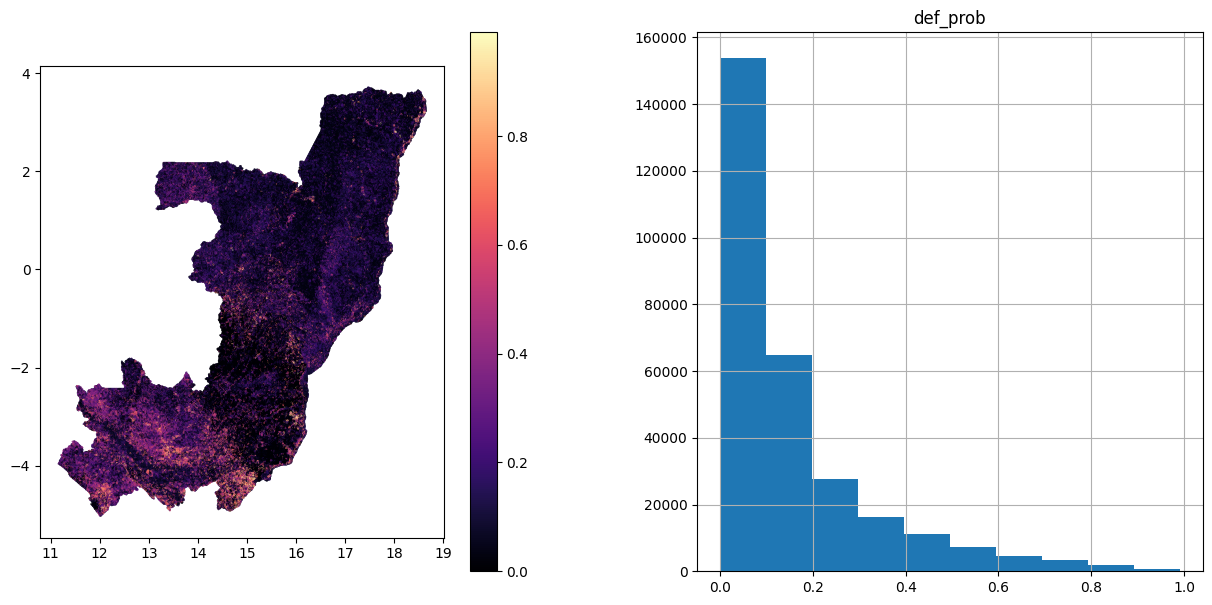

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('def_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('def_prob', ax=ax[1])

In [20]:
# predictors used change/nochange classification
gdf['deg_prob'] = clf.binary_probability_classification(gdf, 'Degall', eSBAE_cols, outlier=False)

OOB Score is 0.7806090739589807


array([<Axes: title={'center': 'deg_prob'}>], dtype=object)

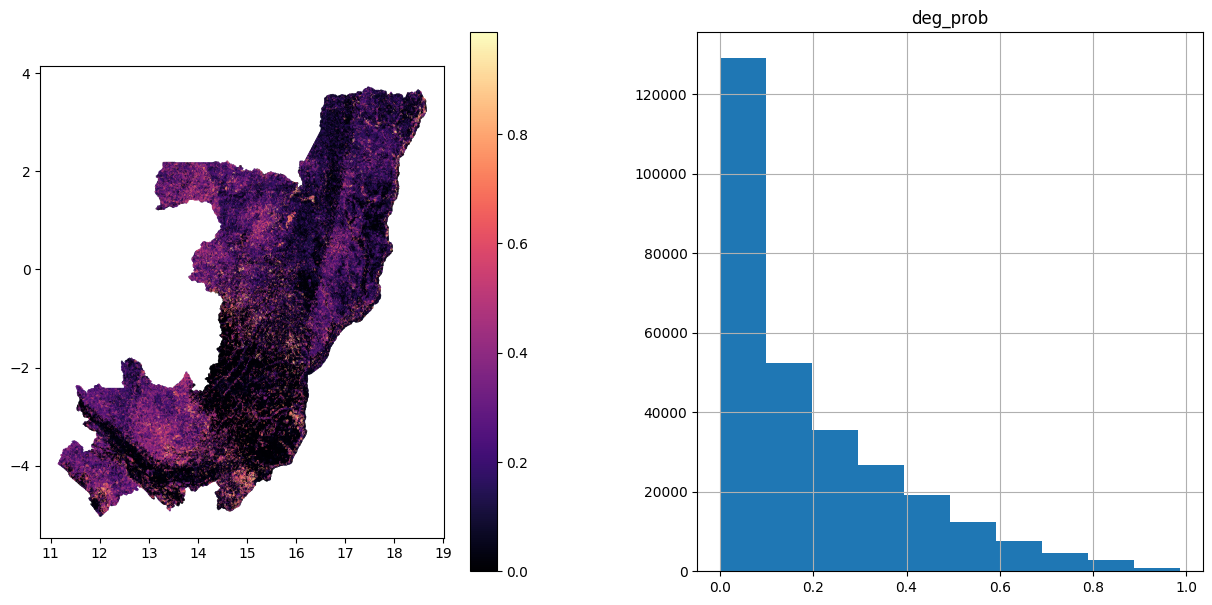

In [21]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('deg_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('deg_prob', ax=ax[1])

In [22]:
# predictors used change/nochange classification
gdf['stable_prob'] = clf.binary_probability_classification(gdf, 'Stable', eSBAE_cols, outlier=False)

OOB Score is 0.8946550652579242


array([<Axes: title={'center': 'stable_prob'}>], dtype=object)

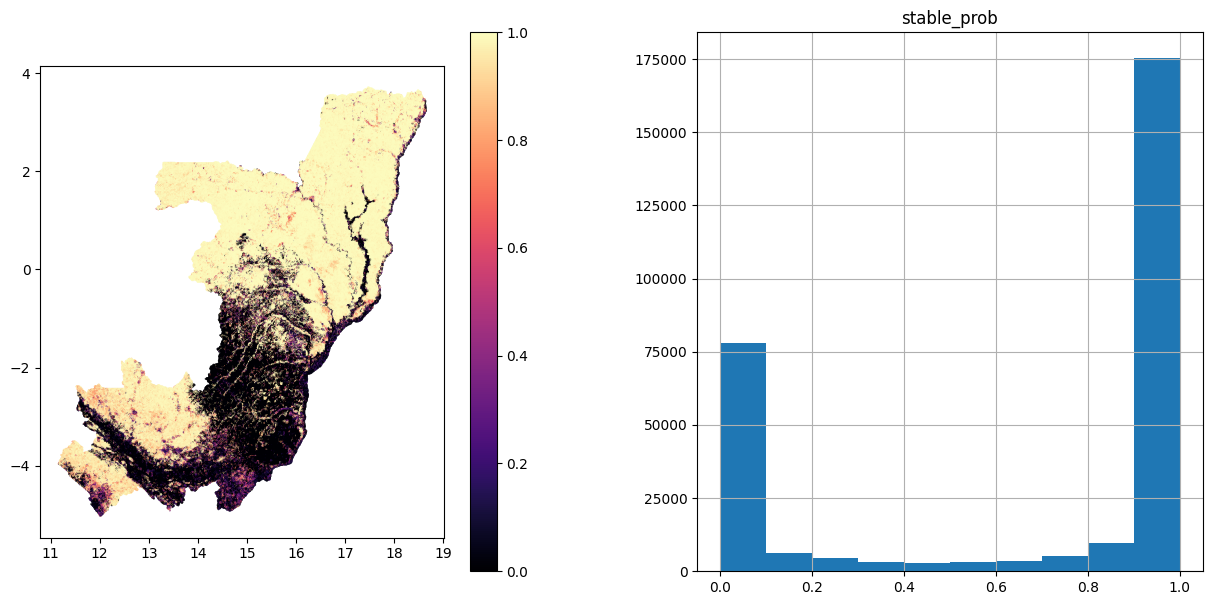

In [23]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('stable_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('stable_prob', ax=ax[1])

In [24]:
# predictors used change/nochange classification
gdf['nf_prob'] = clf.binary_probability_classification(gdf, 'NF', eSBAE_cols, outlier=False)

OOB Score is 0.7976639151711769


array([<Axes: title={'center': 'nf_prob'}>], dtype=object)

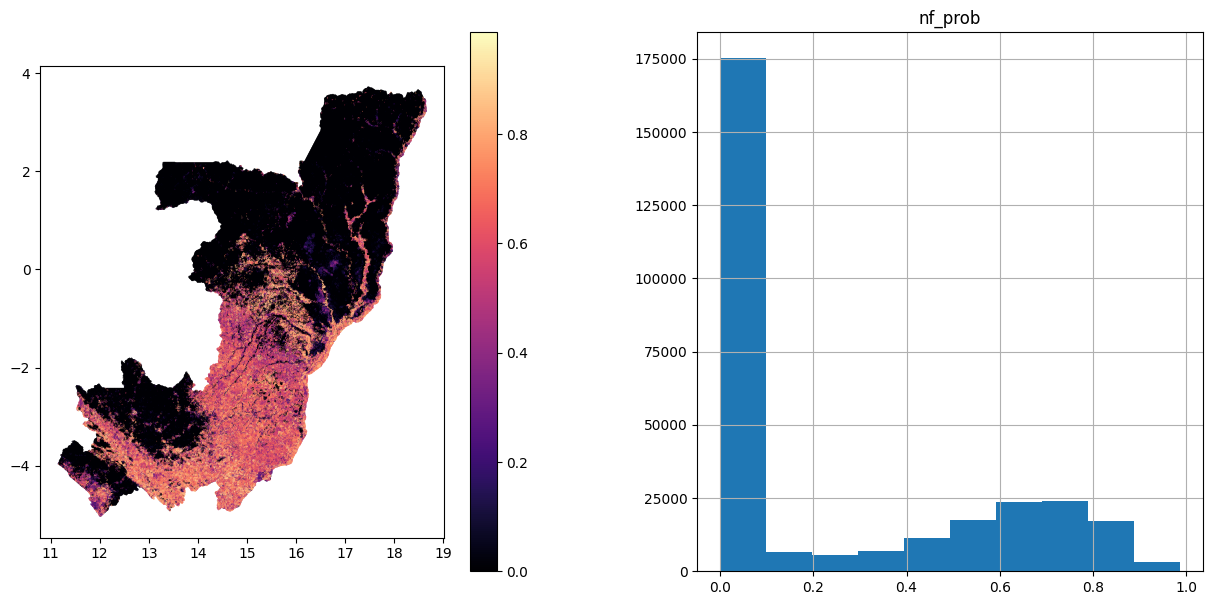

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('nf_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('nf_prob', ax=ax[1])

In [26]:
interpreted_rows = gdf[gdf['interpreted'] == 1]

##### looking at validated data in comparison to model

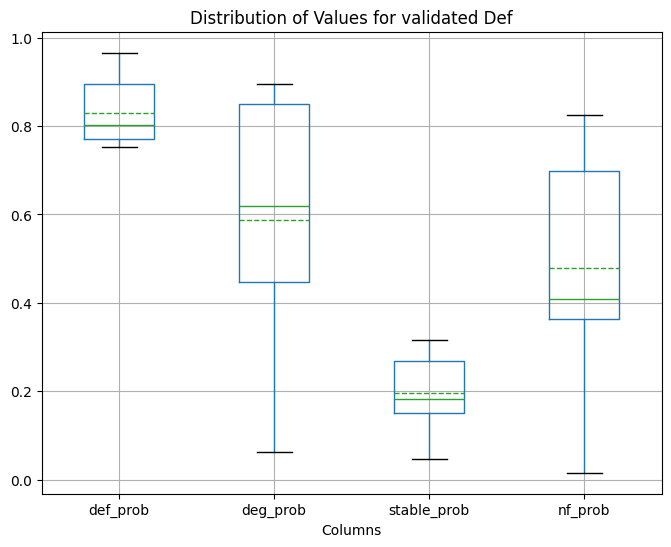

       def_prob  deg_prob  stable_prob   nf_prob
count  9.000000  9.000000     9.000000  9.000000
mean   0.828222  0.588370     0.196963  0.478148
std    0.073694  0.270115     0.086339  0.258708
min    0.752000  0.062667     0.046667  0.016000
25%    0.770000  0.448000     0.150667  0.362667
50%    0.802000  0.620000     0.182667  0.408000
75%    0.895333  0.850667     0.268667  0.698000
max    0.966000  0.895333     0.316667  0.825333


In [27]:
# Filter rows by a interpreted change category 
selected_category = 'Def'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

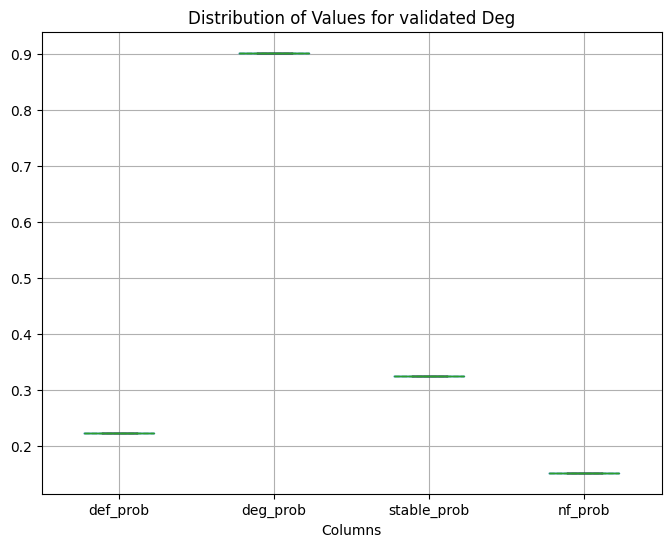

       def_prob  deg_prob  stable_prob  nf_prob
count  1.000000  1.000000     1.000000    1.000
mean   0.222667  0.902667     0.325333    0.152
std         NaN       NaN          NaN      NaN
min    0.222667  0.902667     0.325333    0.152
25%    0.222667  0.902667     0.325333    0.152
50%    0.222667  0.902667     0.325333    0.152
75%    0.222667  0.902667     0.325333    0.152
max    0.222667  0.902667     0.325333    0.152


In [28]:
# Filter rows by a interpreted change category 
selected_category = 'Deg'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

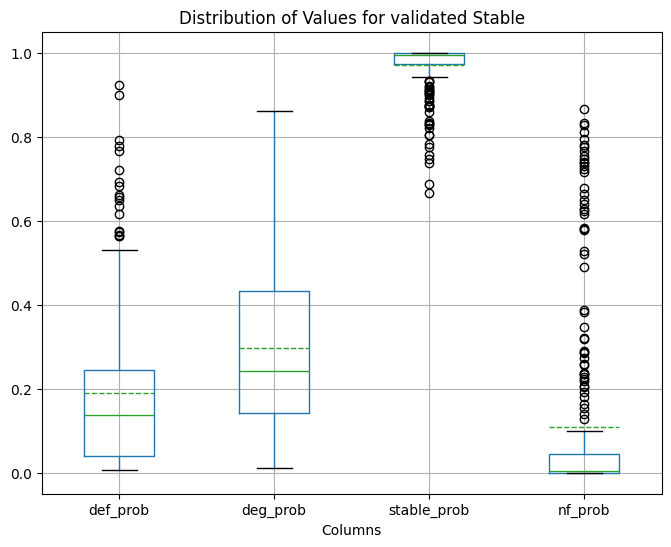

         def_prob    deg_prob  stable_prob     nf_prob
count  250.000000  250.000000   250.000000  250.000000
mean     0.189992    0.295661     0.970837    0.109152
std      0.188048    0.208919     0.056610    0.223352
min      0.006000    0.011333     0.666000    0.000000
25%      0.040167    0.141333     0.973000    0.000000
50%      0.136000    0.241667     0.994667    0.002667
75%      0.243500    0.432167     0.999333    0.045333
max      0.922000    0.860667     1.000000    0.866000


In [29]:
# Filter rows by a interpreted change category 
selected_category = 'Stable'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

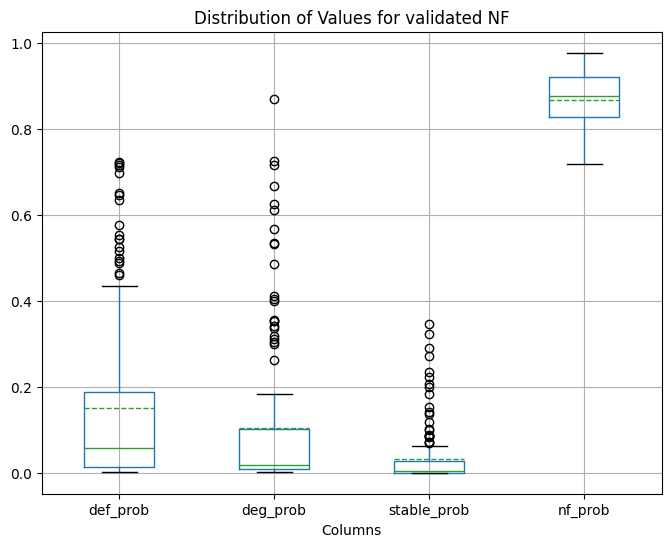

         def_prob    deg_prob  stable_prob     nf_prob
count  143.000000  143.000000   143.000000  143.000000
mean     0.150513    0.103571     0.032228    0.866993
std      0.200717    0.178039     0.066501    0.061831
min      0.000667    0.002000     0.000000    0.718667
25%      0.012000    0.009333     0.000000    0.827667
50%      0.056667    0.018667     0.003333    0.876000
75%      0.188000    0.100667     0.026333    0.921000
max      0.722667    0.869333     0.346667    0.977333


In [30]:
# Filter rows by a interpreted change category 
selected_category = 'NF'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

#### decision tree to assign values to categories from models

In [31]:
threshold = 0.8

In [32]:
gdf['sim_def'] = (gdf['def_prob'] > threshold).astype(int)
gdf['sim_deg'] = (gdf['deg_prob'] > threshold).astype(int)
gdf['sim_stable'] = (gdf['stable_prob'] > threshold).astype(int)
gdf['sim_nf'] = (gdf['nf_prob'] > threshold).astype(int)

In [33]:
gdf['max_prob'] = gdf[['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']].idxmax(axis=1)

# Replace the string in a specific column ('column_name')
gdf['max_prob'] = gdf['max_prob'].str.replace('_prob', '')

gdf['max_prob'].value_counts(dropna=False)

max_prob
stable    191163
nf         93168
deg         4232
def         3036
Name: count, dtype: int64

In [34]:
# Calculate the proportions and areas based on max probability classification
prob_counts = gdf['max_prob'].value_counts()
prob_percentage = (prob_counts / len(gdf)) * 100
area = (prob_percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_prob = pd.DataFrame({
    'Value Counts': prob_counts,
    'Percentage of Total Rows': prob_percentage,
    'area': area
})


# Print the result DataFrame
print(result_prob)

          Value Counts  Percentage of Total Rows     area
max_prob                                                 
stable          191163                        66 22553116
nf               93168                        32 10991817
deg               4232                         1   499285
def               3036                         1   358183


In [35]:
# Define a function to check conditions and return the corresponding label
# check the order of the decisions which has an effect on the result
# in the Gabon case the decisions are in order or area stable > deg > def
def classify(row):
    if row['sim_stable'] >= 1:
        return 'Stable'
    elif row['sim_def'] >= 1:
        return 'Def'
    elif row['sim_deg'] >= 1:
        return 'Deg'
    else:
        return 'NF'

# Apply the function to create a new 'classification' column
gdf['prob_class'] = gdf.apply(classify, axis=1)

# Display the DataFrame with the new column
gdf['prob_class'].value_counts(dropna=False)

prob_class
Stable    185049
NF        102334
Def         2471
Deg         1745
Name: count, dtype: int64

In [36]:
# Calculate the proportions and areas based on decision tree classification
prob_counts = gdf['prob_class'].value_counts()
prob_percentage = (prob_counts / len(gdf)) * 100
area = (prob_percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_prob = pd.DataFrame({
    'Value Counts': prob_counts,
    'Percentage of Total Rows': prob_percentage,
    'area': area
})


# Print the result DataFrame
print(result_prob)

            Value Counts  Percentage of Total Rows     area
prob_class                                                 
Stable            185049                        63 21831795
NF                102334                        35 12073207
Def                 2471                         1   291525
Deg                 1745                         1   205872


In [37]:
# Group by the selected columns and count occurrences
result_df = gdf.groupby(['prob_class', 'Defall', 'Degall', 'Stable', 'NF']).size().reset_index(name='count')

# Display the result
print(result_df)

   prob_class  Defall  Degall  Stable  NF  count
0         Def       0       0       0   1     28
1         Def       0       0       1   0     17
2         Def       0       1       0   0     13
3         Def       1       0       0   0     41
4         Deg       0       0       0   1     10
5         Deg       0       0       1   0      6
6         Deg       0       1       0   0     52
7         Deg       1       0       0   0      1
8          NF       0       0       0   1   1415
9          NF       0       0       1   0    123
10         NF       0       1       0   0     22
11         NF       1       0       0   0     14
12     Stable       0       0       1   0   1476


In [38]:
# Create a new column 'Count' based on the conditions to determine if points are in multiple classes
gdf['Count'] = gdf[['sim_def', 'sim_deg', 'sim_stable', 'sim_nf']].sum(axis=1)

# Display the cross-tabulated counts
cross_tab = pd.crosstab(index=gdf['Count'], columns="Count")
print(cross_tab)

col_0   Count
Count        
0       85524
1      203608
2        2180
3         284
4           3


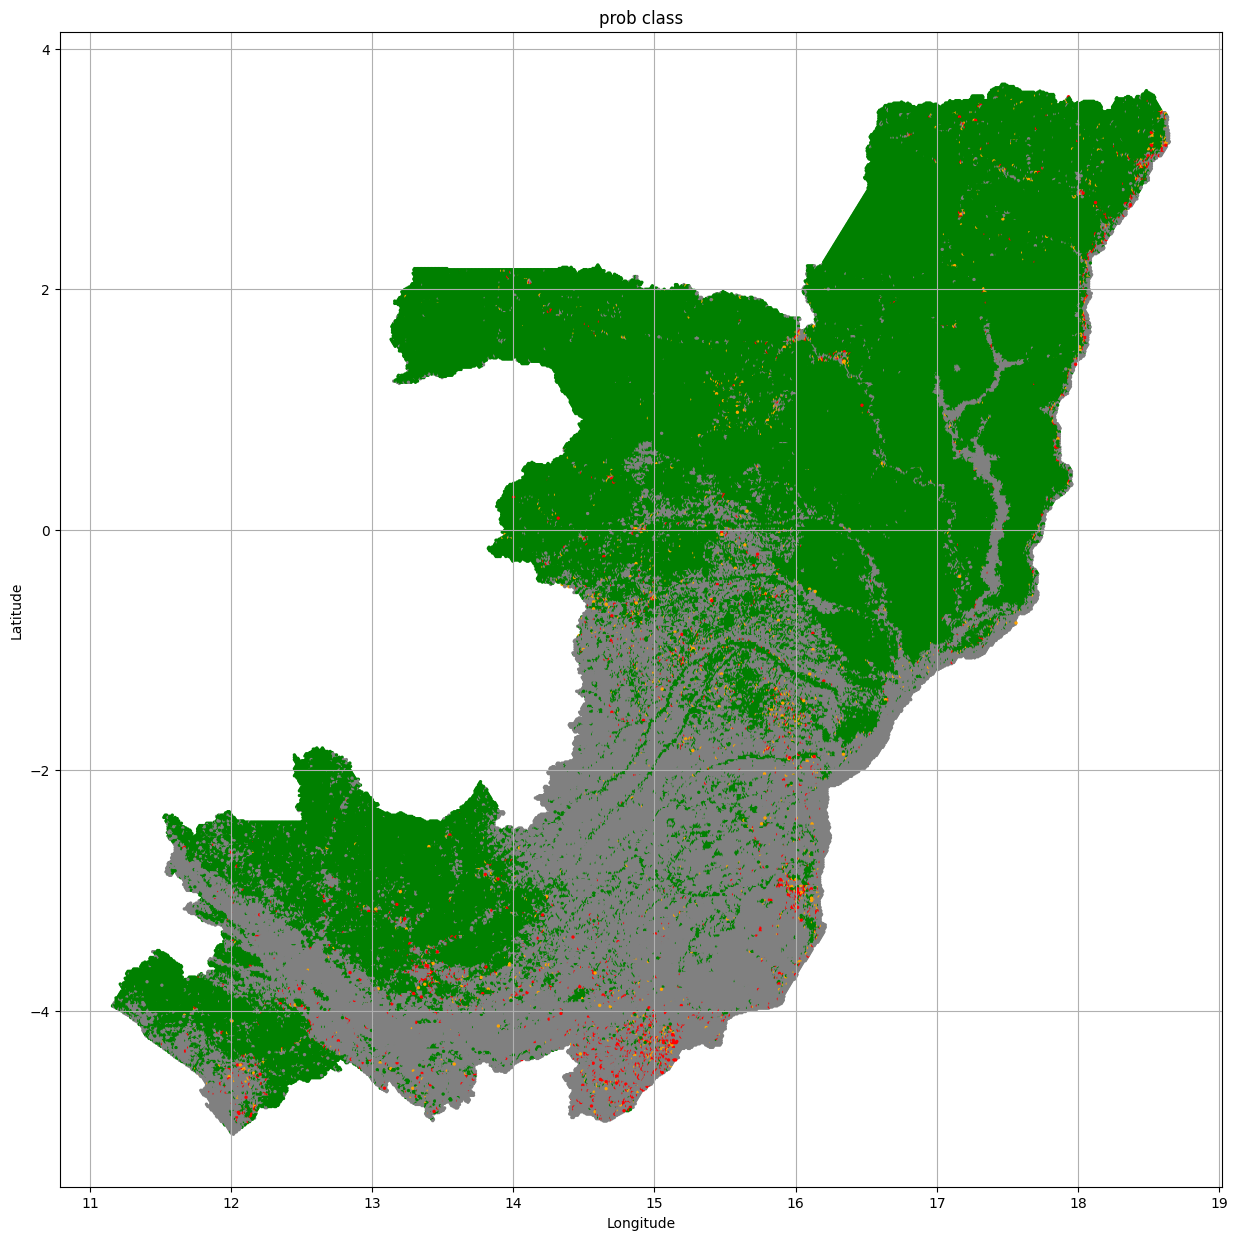

In [39]:
# plot point classes
category_colors = {
    'Def': 'red',
    'Deg': 'orange',
    'Stable': 'green',
    'NF': 'grey'
}

plt.figure(figsize=(15, 15))
plt.scatter(gdf['lon'], gdf['lat'], c=gdf['prob_class'].map(category_colors), s=2)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('prob class')
plt.grid()
plt.show()

#### Supervised classifications

In [ ]:
# Assuming X contains your attribute columns and y contains your target labels
X = interpreted[eSBAE_cols]
y = interpreted['Ref_Change_Type_1522']

In [ ]:
#check for remaining missing counts
missing_counts = {}

# Count missing values and sum the counts by column
for column in X.columns:
    missing_counts[column] = X[column].isna().sum()

# Print the counts
print(missing_counts)

In [ ]:
unique_labels = np.unique(y)
unique_labels = y.value_counts().index
# Specify the unique labels in your target variable as classes
unique_labels = np.unique(y)  # Or use the appropriate method based on your data
unique_labels

In [ ]:
# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y), y=y_train)
class_weights
# Create a dictionary to map class labels to their respective class weights
class_weight_dict = dict(zip(unique_labels, class_weights))
class_weight_dict

In [ ]:
#Balanced random forest classifier
#clf = BalancedRandomForestClassifier(n_estimators=1500, random_state=42, oob_score=True,class_weight=class_weight_dict)
clf = BalancedRandomForestClassifier(n_estimators=1500, random_state=42)

# Fit the classifier to your training data
clf.fit(X_train, y_train)

# Make predictions on new data
gdf['balRF_pred'] = clf.predict(gdf[eSBAE_cols])

y_pred = clf.predict(X_test)

# Get a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

In [ ]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

In [ ]:
# Get feature importances
importances = clf.feature_importances_

# Get column names
column_names = X_train.columns

# Sort feature importances in descending order
indices = (-importances).argsort()

# Plot feature importances with column names
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="skyblue", align="center")
plt.xticks(range(X_train.shape[1]), column_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [ ]:
# Calculate the proportions of classified points
value_counts = gdf['balRF_pred'].value_counts()
percentage = (value_counts / len(gdf)) * 100
area = (percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total Rows': percentage,
    'area': area
})


# Print the result DataFrame
print(result_df)

In [ ]:
# Create an instance of the random forest classifier
#clf = RandomForestClassifier(n_estimators=1000, random_state=42, oob_score=True) # too low
clf = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight=class_weight_dict)
# Fit the classifier to your training data
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Make predictions on new data
gdf['RF_pred'] = clf.predict(gdf[eSBAE_cols])

# Get a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

In [ ]:
# Calculate the proportions
value_counts = gdf['RF_pred'].value_counts()
percentage = (value_counts / len(gdf)) * 100
area = (percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total Rows': percentage,
    'area': area
})


# Print the result DataFrame
print(result_df)

In [ ]:
#CART Model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 3: Predict on the Testing Dataset
y_pred = model.predict(X_test)
gdf['CART_pred'] = model.predict(gdf[eSBAE_cols])
# Step 4: Evaluate the Model (Optional)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy}")

# Get a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

In [ ]:
# Calculate the proportions
value_counts = gdf['CART_pred'].value_counts()
percentage = (value_counts / len(gdf)) * 100
area = (percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total Rows': percentage,
    'area': area
})


# Print the result DataFrame
print(result_df)

In [ ]:
category_colors = {
    'Def': 'red',
    'Deg': 'orange',
    'Stable': 'green',
    'NF': 'grey'
}

plt.figure(figsize=(15, 15))
plt.scatter(gdf['lon'], gdf['lat'], c=gdf['CART_pred'].map(category_colors), s=3)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Random Forest Classification')
plt.grid()
plt.show()

#### add years to all points

In [ ]:
# convert dates to years
gdf['cusum_change_year'] = np.floor(gdf['cusum_change_date']).astype(int)
gdf['ccdc_change_year'] = np.floor(gdf['ccdc_change_date']).astype(int)
gdf['bfast_change_year'] = np.floor(gdf['bfast_change_date']).astype(int)

In [ ]:
# Plotting validated data vs cusum change date
plt.scatter(gdf['Ref_Year'], gdf['cusum_change_date'])
plt.xlabel('Reference Year')
plt.ylabel('cusum change date')
plt.title('Validated year vs cusum change date')
plt.show()

In [ ]:
# plot histogram of cusum change
plt.hist(gdf['cusum_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of cusum_change_year')
plt.xlabel('cusum_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# plot histogram of ccfc change
gdf_ccdc = gdf[gdf['ccdc_change_year']>0]
plt.hist(gdf_ccdc['ccdc_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of ccdc change date')
plt.xlabel('ccdc_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# plot histogram of cusum change
gdf_bfast = gdf[gdf['bfast_change_year']>0]
plt.hist(gdf_bfast['bfast_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of bfast change year')
plt.xlabel('bfast_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##### assign change year classes based on classification and cusum dates

In [ ]:
#choose which model to use
model = 'prob_class'

In [ ]:
# create hybrid column taking the class from the model you choose and combining with cusum date
def y(x):
  if x[model] == 'Def' and x['cusum_change_year'] == 2016: return 'Def2016'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2017: return 'Def2017'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2018: return 'Def2018'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2019: return 'Def2019'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2020: return 'Def2020'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2021: return 'Def2021'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2022: return 'Def2022'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2016: return 'Deg2016'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2017: return 'Deg2017'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2018: return 'Deg2018'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2019: return 'Deg2019'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2020: return 'Deg2020'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2021: return 'Deg2021'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2022: return 'Deg2022'
  elif x[model] == 'Def' and x['cusum_change_year'] > 2022: return 'Stable'  
  elif x[model] == 'Deg' and x['cusum_change_year'] > 2022: return 'Stable'  
  elif x[model] == 'Def' and x['cusum_change_year'] < 2016: return 'Stable' 
  elif x[model] == 'Deg' and x['cusum_change_year'] < 2016: return 'Stable' 
  elif x[model] == 'Stable' : return 'Stable'
  elif x[model] == 'NF' : return 'NF'
  else: return ''

gdf['Sim_Ref_Change_Year_1522'] = gdf.apply(y, axis=1)

annual_counts = gdf['Sim_Ref_Change_Year_1522'].value_counts()
annual_counts = annual_counts.sort_index()
print(annual_counts)

In [ ]:
#create hybrid column with values keeping interpreted data, and modeled for all the rest
gdf['Sim_CEO_Ref_Change_Type_1522'] = np.where(gdf['interpreted'] == 1, gdf['Ref_Change_Type_1522'], gdf[model])
gdf['Sim_CEO_Ref_Change_Year_1522'] = np.where(gdf['interpreted'] == 1, gdf['Ref_Change_Year_1522'], gdf['Sim_Ref_Change_Year_1522'])

In [ ]:
gdf['Sim_CEO_Ref_Change_Type_1522'].value_counts(dropna=False)

In [ ]:
gdf['Sim_CEO_Ref_Change_Year_1522'].value_counts(dropna=False).sort_index()

In [ ]:
#check that interpreted values sum correctly
pd.pivot_table(gdf,values='point_id',index=['Sim_CEO_Ref_Change_Year_1522'],columns=['interpreted'],aggfunc="count",margins=True,
                             margins_name='Total')

In [ ]:
#check that interpreted values sum correctly
pd.pivot_table(gdf,values='point_id',index=['Sim_CEO_Ref_Change_Type_1522'],columns=['stratum'],aggfunc="count",margins=True,
                             margins_name='Total')

In [ ]:
#check that interpreted values sum correctly
pd.pivot_table(gdf,values='point_id',index=['Sim_CEO_Ref_Change_Year_1522'],columns=['stratum'],aggfunc="count",margins=True,
                             margins_name='Total')

In [ ]:
#use stratum counts to calculate stats from CEO  points
pd.pivot_table(gdf,values='point_id',index=['Ref_Change_Year_1522'],columns=['stratum'],aggfunc="count",margins=True,
                             margins_name='Total')

#### plot data

In [ ]:
#select the values you want to plot
values_to_plot = ['Def2016','Def2017','Def2018','Def2019','Def2020','Def2021','Def2022']

# Filter the DataFrame to include only the selected values
filtered_df = gdf[gdf['Sim_CEO_Ref_Change_Year_1522'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
defvalue_counts = filtered_df['Sim_CEO_Ref_Change_Year_1522'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
defvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of def points per year')

# Show the plot
plt.show()

In [ ]:
#select the values you want to plot
values_to_plot = ['Deg2016','Deg2017','Deg2018','Deg2019','Deg2020','Deg2021','Deg2022']

# Filter the DataFrame to include only the selected values
filtered_df = gdf[gdf['Sim_CEO_Ref_Change_Year_1522'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
defvalue_counts = filtered_df['Sim_CEO_Ref_Change_Year_1522'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
defvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of deg points per year')

# Show the plot
plt.show()

In [ ]:
#export
#out_file =  '/home/sepal-user/module_results/esbae/DRC/DRC_esbae_supervised_class_1522.csv'
#out_file =  '/home/sepal-user/module_results/esbae/GAB/GAB_esbae_supervised_class_1522.csv'
out_file =  '/home/sepal-user/module_results/esbae/EQG/EQG_esbae_supervised_class_1522.csv'

gdf.to_csv(out_file,index=True)